In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG19
 

In [2]:
from tensorflow.keras.models import load_model
 
# Define your custom loss exactly as it was during training
def combined_loss(y_true, y_pred):
    # Example: replace with your actual loss function
    import tensorflow as tf
    return tf.reduce_mean(tf.square(y_true - y_pred))
 
# Load model with custom loss
model = load_model("cartoon_model.keras", custom_objects={'combined_loss': combined_loss})
 

In [3]:
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
 
def cartoonize_postprocess(img, k=8, smooth_strength=0.4, color_preserve=True):
    img = np.array(img * 255, dtype=np.uint8)
    smooth = cv2.bilateralFilter(img, d=9, sigmaColor=90, sigmaSpace=90)
 
    if not color_preserve:
        Z = img.reshape((-1, 3))
        Z = np.float32(Z)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        smooth = res.reshape(img.shape)
 
    dark = cv2.convertScaleAbs(smooth, alpha=1.2, beta=-25)
    return dark.astype(np.uint8) / 255.0

In [4]:
def cartoon_simple_black_outline_flat_colors(original,
                                             line_thickness=0.005,  # thickness of black outline
                                             n_colors=8         # number of flat cartoon colors
                                            ):
    """
    Convert an image to a classic cartoon style:
    - Strong black outlines
    - Flat uniform colors (k-means quantization)
   
    Parameters:
    original: np.array or tf.Tensor of shape (H,W,3) with values [0,1]
    line_thickness: thickness of black outlines
    n_colors: number of flat cartoon colors inside
   
    Returns:
    cartoon_result: np.array of shape (H,W,3) with cartoonified image
    """
    import cv2, numpy as np
    import tensorflow as tf
 
    # --- Convert tensors to numpy ---
    if isinstance(original, tf.Tensor):
        original = original.numpy()
    original = np.clip(original, 0, 1)
 
    # --- Step 1: Reduce colors using k-means (flat cartoon colors) ---
    img_flat = (original*255).reshape(-1,3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    _, labels, centers = cv2.kmeans(img_flat, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    flat_colors = centers[labels.flatten()].reshape(original.shape).astype(np.float32)/255.0
 
    # --- Step 2: Detect strong edges ---
    gray = cv2.cvtColor((original*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
 
    # --- Step 3: Dilate edges for thicker black outlines ---
    kernel = np.ones((line_thickness, line_thickness), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
 
    # --- Step 4: Create black edge mask ---
    edges_mask = (edges > 0).astype(np.float32)
    edges_mask = np.stack([edges_mask]*3, axis=-1)
 
    # --- Step 5: Combine black edges with flat colors ---
    cartoon_result = flat_colors * (1 - edges_mask)  # inside colors
    cartoon_result += edges_mask * 0                  # black edges
 
    return np.clip(cartoon_result, 0, 1)
 

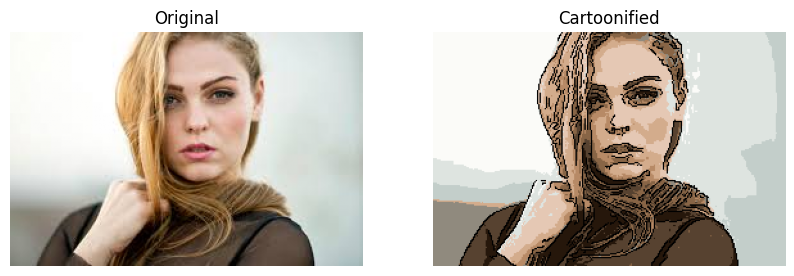

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import cv2
 
# Load image
img_path = r"C:\Deep Learning Tasks\CNN\CARTOON\cartoon_dataset\1.jpg"
img = load_img(img_path).convert("RGB")
img_array = np.array(img)/255.0
 
# Cartoonify
cartoon = cartoon_simple_black_outline_flat_colors(img_array, line_thickness=1, n_colors=10)
 
# Display
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img_array)
plt.axis('off')
 
plt.subplot(1,2,2)
plt.title("Cartoonified")
plt.imshow(cartoon)
plt.axis('off')
plt.show()
 

In [6]:
import cv2
import numpy as np
 
def cartoon_simple_black_outline_flat_colors(frame,
                                             line_thickness=2,
                                             n_colors=24):
    """
    Cartoonify a single frame with flat colors and black outlines.
    frame: BGR image from OpenCV (values 0-255)
    """
    import cv2, numpy as np
 
    # Convert BGR to RGB and scale to [0,1]
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
 
    # --- Step 1: Reduce colors using k-means ---
    img_flat = (img*255).reshape(-1,3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    _, labels, centers = cv2.kmeans(img_flat, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    flat_colors = centers[labels.flatten()].reshape(img.shape).astype(np.float32)/255.0
 
    # --- Step 2: Detect edges ---
    gray = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
 
    # --- Step 3: Dilate edges for thicker black outline ---
    kernel = np.ones((line_thickness, line_thickness), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
 
    edges_mask = (edges > 0).astype(np.float32)
    edges_mask = np.stack([edges_mask]*3, axis=-1)
 
    # --- Step 4: Combine black edges with flat colors ---
    cartoon_result = flat_colors * (1 - edges_mask)
    cartoon_result += edges_mask * 0  # black edges
 
    # Convert back to BGR 0-255 for OpenCV
    cartoon_result = (cartoon_result*255).astype(np.uint8)
    cartoon_result = cv2.cvtColor(cartoon_result, cv2.COLOR_RGB2BGR)
    return cartoon_result
 
 
# --- Capture photo from webcam ---
cap = cv2.VideoCapture(0)  # 0 = default camera
print("Press SPACE to capture a photo, or ESC to exit.")
 
while True:
    ret, frame = cap.read()
    if not ret:
        break
 
    cv2.imshow("Webcam - Press SPACE to Capture", frame)
    key = cv2.waitKey(1)
 
    if key == 27:  # ESC key
        print("Exiting without capturing.")
        cap.release()
        cv2.destroyAllWindows()
        exit()
    elif key == 32:  # SPACE key
        photo = frame.copy()
        break
 
cap.release()
cv2.destroyAllWindows()
 
# --- Cartoonify the captured photo ---
cartoon_photo = cartoon_simple_black_outline_flat_colors(photo, line_thickness=1, n_colors=12)
 
# --- Show the cartoonified image ---
cv2.imshow("Cartoonified Photo", cartoon_photo)
cv2.waitKey(0)
cv2.destroyAllWindows()
 
# --- Save the cartoon image ---
save_path = "cartoon_photo6.png"
cv2.imwrite(save_path, cartoon_photo)
print(f"Cartoonified photo saved to {save_path}")

Press SPACE to capture a photo, or ESC to exit.
Cartoonified photo saved to cartoon_photo6.png
